In [1]:
import pandas as pd
import numpy as np

import tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn import metrics

import matplotlib.pyplot as plt
from functools import reduce

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read data
df = pd.read_csv("/Users/luzhang/Desktop/data/AMZN.csv")
df = pd.DataFrame(df)
# drop nas
df = df.dropna()

In [3]:
df.shape

(1335090, 6)

In [4]:
# data pre-cessing
#change sereis to datetime format
df['time']=pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

In [5]:
# Define Drop outlier day function to drop the incomplete transcation days
def DropOutlierday(data):
    # subset dataframe such that it only contains the complete transcation
    totalDay=pd.to_datetime(data.index.date).unique()
    completeDay=totalDay[day_keep]

    outlierday=totalDay.difference(completeDay)
    data['date'] = [d.date() for d in data.index]

    outlierday=outlierday.strftime('%Y-%m-%d')
    t=pd.DataFrame()
    
    for i in range(len(outlierday)):
        temp=pd.DataFrame(data['date'].loc[outlierday[i]])
        t=t.append(temp)
    
    data = data.drop(t.index) # drop the outlier day
    data = data.drop('date',1) # delete columne 'date'
    return data

## returns calculation

##### R_LH0 and R_LH 

In [6]:
#subset df to calculate LH and LH0 
df_LH_LH0 = df[((df.index.hour == 15) & (df.index.minute == 30))|
        ((df.index.hour == 16) & (df.index.minute == 0))]
#df_LH_LH0

In [7]:
# find the complete transaction
rows_eachday = df_LH_LH0.groupby(df_LH_LH0.index.date).size().values
day_keep = [True if x==2 else False for x in rows_eachday]
sum(day_keep)

2866

In [8]:
df_LH_LH0 = DropOutlierday(df_LH_LH0)
df_LH_LH0['returns'] = df_LH_LH0['close'].pct_change()

In [9]:
df_LH = df_LH_LH0[((df_LH_LH0.index.hour == 16) & (df_LH_LH0.index.minute == 0))]
df_LH = df_LH.drop(['open','high','low','close','volume'],1)
df_LH = df_LH.rename(columns={"returns":"R_LH"})

In [10]:
df_LH0=df_LH.shift()
df_LH0=df_LH0.rename(columns={'R_LH':'R_LH0'})

##### R_ROD

In [11]:
#subset df to calculate ROD
df_ROD = df[((df.index.hour == 15) & (df.index.minute == 30))|
        ((df.index.hour == 16) & (df.index.minute == 0))]
#df_ROD

In [12]:
# find the complete transaction
rows_eachday = df_ROD.groupby(df_ROD.index.date).size().values
day_keep = [True if x==2 else False for x in rows_eachday]
sum(day_keep)

2866

In [13]:
df_ROD  = DropOutlierday(df_ROD)
df_ROD['returns'] = df_ROD['close'].pct_change()

In [14]:
df_ROD=df_ROD[((df_ROD.index.hour == 15) & (df_ROD.index.minute == 30))]
df_ROD=df_ROD.drop(['open','high','low','close','volume'],1)
df_ROD=df_ROD.rename(columns={'returns':'R_ROD'})

### R_ON

In [15]:
df_ON=df[((df.index.hour == 9) & (df.index.minute == 31))|
        ((df.index.hour == 16) & (df.index.minute == 0))]
# Larry: 9:31 is the data for the first minute which is better than using the data for 9:29~9:30

In [16]:
rows_eachday = df_ON.groupby(df_ON.index.date).size().values
day_keep = [True if x==2 else False for x in rows_eachday]
sum(day_keep)

2866

In [17]:
df_ON  = DropOutlierday(df_ON)
df_ON['close_pre'] = df_ON['close'].shift()

In [18]:
df_ON = df_ON[((df_ON.index.hour == 9) & (df_ON.index.minute == 31))]

In [19]:
df_ON['R_ON'] = df_ON['open']/df_ON['close_pre']-1;
df_ON = df_ON.drop(["open","high","low","close","volume","close_pre"],1)

### R_FH

In [20]:
df_FH = df[((df.index.hour == 9) & (df.index.minute == 31))|
        ((df.index.hour == 10) & (df.index.minute == 0))]
# Larry: use 9:31 data
#df_FH

In [21]:
rows_eachday = df_FH.groupby(df_FH.index.date).size().values
day_keep = [True if x==2 else False for x in rows_eachday]
sum(day_keep)

2889

In [22]:
df_FH = DropOutlierday(df_FH)

In [23]:
df_FH['open_pre30']=df_FH['open'].shift()

In [24]:
df_FH=df_FH[(df_FH.index.hour==10)&(df_FH.index.minute==0)]

In [25]:
df_FH['R_FH'] = df_FH['open']/df_FH['open_pre30']-1
df_FH = df_FH.drop(["open","high","low","close","open_pre30",'volume'],1)

### R_ONFH

In [26]:
df_ONFH = df[((df.index.hour==16)&(df.index.minute==0))|
            ((df.index.hour==10)&(df.index.minute==0))]

In [27]:
rows_eachday = df_ONFH.groupby(df_ONFH.index.date).size().values
day_keep = [True if x==2 else False for x in rows_eachday]
sum(day_keep)

2867

In [28]:
df_ONFH = DropOutlierday(df_ONFH)

In [29]:
df_ONFH['close_preday']=df_ONFH['close'].shift()

In [30]:
df_ONFH=df_ONFH[((df_ONFH.index.hour==10)&(df_ONFH.index.minute==0))]
df_ONFH['R_ONFH']=df_ONFH['open']/df_ONFH['close_preday']-1
df_ONFH = df_ONFH.drop(['open','high','low','close','volume','close_preday'],1)

### R_M

In [31]:
df_M = df[((df.index.hour==10)&(df.index.minute==0)) |
         ((df.index.hour==15)&(df.index.minute==0))]

In [32]:
rows_eachday = df_M.groupby(df_M.index.date).size().values
day_keep = [True if x==2 else False for x in rows_eachday]
sum(day_keep)

2861

In [33]:
df_M = DropOutlierday(df_M)

In [34]:
df_M['open_past30'] = df_M['open'].shift()
df_M = df_M[((df_M.index.hour==15)&(df_M.index.minute==0))]
df_M['R_M'] = df_M['close']/df_M['open_past30']-1
df_M = df_M.drop(['open','high','low','close','open_past30','volume'],1)
#df_M

### R_SLH

In [35]:
df_SLH = df[((df.index.hour==15)&(df.index.minute==30)) |
           ((df.index.hour==15)&(df.index.minute==0))]

In [36]:
rows_eachday = df_SLH.groupby(df_SLH.index.date).size().values
day_keep = [True if x==2 else False for x in rows_eachday]
sum(day_keep)

2861

In [37]:
df_SLH = DropOutlierday(df_SLH)

In [38]:
df_SLH['close_pre60'] = df_SLH['close'].shift()
df_SLH = df_SLH[((df_SLH.index.hour==15)&(df_SLH.index.minute==30))]
df_SLH['R_SLH'] = df_SLH['close']/df_SLH['close_pre60']-1
df_SLH = df_SLH.drop(['open','high','low','close','volume','close_pre60'],1)

In [39]:
# keep the date and ignore the time
df_LH['new_date'] = [d.date() for d in df_LH.index]
df_LH0['new_date'] = [d.date() for d in df_LH0.index]
df_ROD['new_date'] = [d.date() for d in df_ROD.index]
df_ON['new_date'] = [d.date() for d in df_ON.index]
df_FH['new_date'] = [d.date() for d in df_FH.index]
df_ONFH['new_date'] = [d.date() for d in df_ONFH.index]
df_M['new_date'] = [d.date() for d in df_M.index]
df_SLH['new_date'] = [d.date() for d in df_SLH.index]

In [41]:
# merge by same date
data_frames=[df_LH, df_LH0, df_ROD, df_ON, df_FH, df_ONFH, df_M, df_SLH]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['new_date'],
                                            how='inner'), data_frames)

In [42]:
df_merged=df_merged.rename(columns={'new_date':'datetime'})

In [43]:
df_merged

,R_LH,datetime,R_LH0,R_ROD,R_ON,R_FH,R_ONFH,R_M,R_SLH
0,-0.006806,2007-04-30,0.005461,-0.014217,NaN,0.000162,NaN,-0.003553,0.000162
1,0.010753,2007-05-01,-0.006806,0.001468,-0.002774,-0.005399,-0.008158,0.011022,-0.001302
2,-0.001632,2007-05-02,0.010753,-0.012411,-0.005803,-0.001459,-0.007253,-0.004059,-0.001141
3,0.001288,2007-05-03,-0.001632,0.015204,-0.001471,0.000164,-0.001308,0.017188,-0.000644
4,0.005721,2007-05-04,0.001288,0.012062,0.003377,0.015547,0.018977,-0.006944,0.000159
...,...,...,...,...,...,...,...,...,...
2854,0.003023,2018-10-26,-0.005102,-0.081181,-0.072415,0.003014,-0.069619,-0.012246,-0.000184
2855,0.013736,2018-10-29,0.003023,-0.073938,0.013759,-0.015342,-0.001794,-0.064634,-0.008168
2856,0.006944,2018-10-30,0.013736,-0.012464,-0.034068,0.036207,0.000905,-0.016812,0.003514
2857,-0.005479,2018-10-31,0.006944,0.050994,0.025575,0.017118,0.043131,0.008170,-0.000627


In [44]:
df_merged=df_merged.set_index('datetime')

In [45]:
df_merged = df_merged.dropna()

In [46]:
df_merged.to_csv("/Users/luzhang/Documents/GitHub/WrappingUp_Exploring_Intraday_Momentum_2rd_try/Data/AMZN_Returns_updates.csv", index=True)

## Market regime label generating

In [47]:
day_ROD = df[((df.index.hour == 9) & (df.index.minute == 30))|
        ((df.index.hour == 15) & (df.index.minute == 30))]
day_ROD

,open,high,low,close,volume
time,,,,,
2007-04-27 15:30:00,62.2200,62.2700,62.210,62.26,30875.0
2007-04-30 15:30:00,61.6500,61.7200,61.650,61.71,32433.0
2007-05-01 15:30:00,61.4600,61.4600,61.370,61.38,31082.0
2007-05-02 15:30:00,61.2500,61.2800,61.240,61.27,55813.0
2007-05-03 15:30:00,62.0800,62.1500,62.080,62.10,68496.0
...,...,...,...,...,...
2018-10-30 15:30:00,1524.3385,1524.3385,1518.490,1519.43,9612.0
2018-10-31 09:30:00,1566.7500,1570.2500,1566.750,1570.25,900.0
2018-10-31 15:30:00,1605.4158,1608.2100,1605.230,1608.00,7565.0


In [48]:
# find the complete transaction between 9:30-15:30 
rows_eachday = day_ROD.groupby(day_ROD.index.date).size().values
day_keep = [True if x==2 else False for x in rows_eachday]
sum(day_keep)

2332

In [49]:
day_ROD = DropOutlierday(day_ROD)

In [50]:
# find the unique date on df_LH0
unidate = pd.to_datetime(day_ROD.index.date).unique()
unidate

DatetimeIndex(['2007-08-20', '2007-09-24', '2007-09-25', '2007-09-26',
               '2007-09-27', '2007-10-01', '2007-10-02', '2007-10-03',
               '2007-10-04', '2007-10-05',
               ...
               '2018-10-19', '2018-10-22', '2018-10-23', '2018-10-24',
               '2018-10-25', '2018-10-26', '2018-10-29', '2018-10-30',
               '2018-10-31', '2018-11-01'],
              dtype='datetime64[ns]', length=2332, freq=None)

In [51]:
# set up the time between 9:30 and 15:30
T_1530 = '15:30:00'
T_930 = '9:30:00'
T_1530 = pd.to_timedelta(T_1530)
T_930 = pd.to_timedelta(T_930)
# prepare the start and end point 
date1530 = unidate+T_1530
date930 = unidate+T_930

In [52]:
# calculate log-return (ln(p_t)-ln(p_{t-1}))
log_return = list()
for i in range(len(unidate)-1):
    temp_df = df[date930[i]:date1530[i]]['close']
    if len(temp_df)==361:
        temp_df_shift = df[date930[i]:date1530[i]]['close'].shift(1)
        temp = np.log(temp_df)- np.log(temp_df_shift)
        temp = temp.rename(str(unidate[i]))
        log_return.append(temp)
    else:
        i = i+1

In [53]:
# convert log_return list to the dataframe 
Log_Return = log_return[0]
Log_Return = pd.DataFrame(Log_Return)
Log_Return.reset_index('time',drop = True,inplace=True)
Log_Return.columns = Log_Return.columns.str.replace('00:00:00','')

for i in np.arange(1,len(log_return)):
    temp = log_return[i]
    temp = pd.DataFrame(temp)
    temp.reset_index('time',drop = True,inplace=True)
    temp.columns = temp.columns.str.replace('00:00:00','')
    Log_Return = Log_Return.join(temp)

In [54]:
log_return = pd.DataFrame(Log_Return)
log_return = log_return.dropna()
log_return

,2007-09-24,2007-09-25,2007-09-26,2007-09-27,2007-10-01,2007-10-02,2007-10-03,2007-10-05,2007-10-08,2007-10-09,...,2018-10-18,2018-10-19,2018-10-22,2018-10-23,2018-10-24,2018-10-25,2018-10-26,2018-10-29,2018-10-30,2018-10-31
1,0.001532,0.001305,-0.000212,-0.000638,0.001709,-0.001386,0.003368,-0.000855,0.001061,0.000725,...,-0.002422,-0.004804,-0.001245,-0.006587,0.002360,-0.000743,-0.000822,0.001258,-0.003093,0.000255
2,0.000219,-0.001414,0.001168,-0.000851,0.001387,-0.002778,0.000000,-0.000428,-0.000954,-0.003316,...,0.001599,-0.003519,0.000018,0.004361,-0.000991,0.001916,-0.008799,-0.006414,0.008020,0.002273
3,0.001202,-0.000436,-0.000425,-0.000213,0.000105,-0.002904,-0.003586,0.000000,0.004235,-0.001766,...,-0.003024,0.002017,-0.000701,0.001726,-0.006810,0.002298,-0.011070,-0.001790,0.011911,0.003934
4,-0.003172,-0.000109,-0.001275,-0.001812,-0.003950,-0.002460,0.000108,-0.001499,-0.001480,-0.000624,...,0.000974,0.001521,0.001978,-0.002024,-0.001811,-0.002861,-0.006713,0.003295,-0.005264,-0.004077
5,-0.001206,0.001198,-0.005651,-0.001174,-0.000749,0.000108,0.000545,-0.000965,-0.000106,-0.000833,...,0.001312,-0.002860,-0.000386,0.004106,0.000377,-0.000270,0.007621,-0.006126,-0.001543,0.001239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,-0.000217,0.000000,0.000321,0.000081,-0.000537,-0.000048,0.000054,0.000107,-0.000524,-0.000313,...,0.000292,0.001213,0.000010,0.000372,0.001849,-0.001909,-0.002429,0.002268,0.001669,-0.000768
357,0.000000,0.000000,0.000748,0.000000,0.001073,-0.000169,-0.000008,-0.000429,-0.001028,-0.000731,...,0.000248,0.001163,0.000396,0.000152,0.001257,0.000431,0.000849,-0.001612,0.000455,0.000068
358,0.000542,0.001501,-0.001711,-0.000857,0.000107,0.000326,-0.000101,-0.000751,-0.000126,-0.000941,...,0.000417,-0.000017,0.000468,-0.000536,-0.003164,0.000000,0.001604,-0.004490,0.002020,0.000006
359,0.000000,-0.001608,0.000321,0.000750,-0.000054,-0.000326,-0.000119,0.001180,0.000000,-0.000209,...,0.000859,0.000917,0.000049,0.000152,-0.002270,-0.000101,0.000611,0.001853,0.002032,-0.000704


In [55]:
test = log_return
test = test.T
test

,1,2,3,4,5,6,7,8,9,10,...,351,352,353,354,355,356,357,358,359,360
2007-09-24,0.001532,0.000219,0.001202,-0.003172,-0.001206,-0.000001,-0.001426,-0.001099,0.003841,0.000876,...,0.002066,0.000543,0.000434,0.000651,-0.000325,-0.000217,0.000000,0.000542,0.000000,0.001300
2007-09-25,0.001305,-0.001414,-0.000436,-0.000109,0.001198,0.000760,-0.001522,0.001197,-0.000544,-0.003707,...,0.000536,-0.000215,0.000000,-0.000429,0.000429,0.000000,0.000000,0.001501,-0.001608,0.000322
2007-09-26,-0.000212,0.001168,-0.000425,-0.001275,-0.005651,0.002349,-0.000107,0.000533,0.000533,-0.000960,...,0.000642,0.000127,0.000622,-0.000107,0.000000,0.000321,0.000748,-0.001711,0.000321,0.000535
2007-09-27,-0.000638,-0.000851,-0.000213,-0.001812,-0.001174,0.000320,0.001707,0.000320,0.000447,0.000192,...,0.000321,0.000000,0.000000,0.000214,-0.000509,0.000081,0.000000,-0.000857,0.000750,0.000321
2007-10-01,0.001709,0.001387,0.000105,-0.003950,-0.000749,-0.000107,0.002352,0.001601,0.000959,0.002139,...,0.000107,0.000107,-0.000643,-0.001073,0.000751,-0.000537,0.001073,0.000107,-0.000054,0.000054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-25,-0.000743,0.001916,0.002298,-0.002861,-0.000270,0.002999,-0.001657,-0.002493,-0.001825,-0.000303,...,0.000112,-0.002087,0.000039,0.000470,0.000755,-0.001909,0.000431,0.000000,-0.000101,0.001500
2018-10-26,-0.000822,-0.008799,-0.011070,-0.006713,0.007621,0.008448,0.003623,0.003847,-0.002870,0.001963,...,-0.000725,0.001242,0.002736,-0.002657,-0.000067,-0.002429,0.000849,0.001604,0.000611,-0.001248
2018-10-29,0.001258,-0.006414,-0.001790,0.003295,-0.006126,0.000851,0.001348,-0.000452,0.001378,-0.004581,...,-0.003077,-0.000390,0.003722,0.002655,-0.000558,0.002268,-0.001612,-0.004490,0.001853,-0.001800
2018-10-30,-0.003093,0.008020,0.011911,-0.005264,-0.001543,-0.007323,-0.003112,0.006198,-0.000398,-0.001071,...,-0.000846,-0.001672,-0.001850,0.000200,0.001260,0.001669,0.000455,0.002020,0.002032,-0.003064


In [56]:
# convert to array
df_train = np.array(test).reshape(test.shape[0],test.shape[1],1)
df_train = df_train.astype(object)

In [57]:
dba_km = TimeSeriesKMeans(n_clusters=2,
                          n_init=2,
                          metric="dtw",
                          random_state=666)


In [58]:
y_pred = dba_km.fit_predict(df_train)
labels = dict(zip(test.index, y_pred))

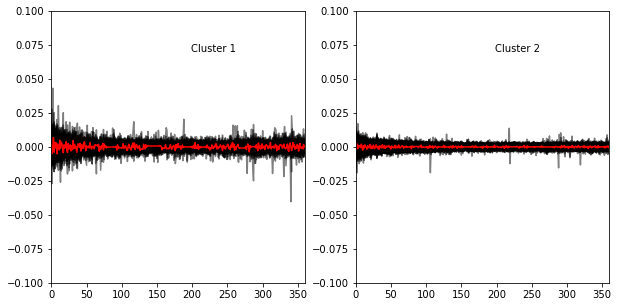

In [59]:
plt.figure(figsize=(10, 5))
for yi in range(2):
    plt.subplot(1, 2, yi + 1)
    for xx in df_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.5)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, 360)
    plt.ylim(-0.1, 0.1)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    plt.savefig("/Users/luzhang/Desktop/wrap up/AMZN_regime.pdf", format = "pdf")

In [60]:
data_labels = labels.items()
data_list = list(data_labels)

df_labels = pd.DataFrame(data_list)
df_labels.columns=['datetime','regime']
df_labels = df_labels.set_index('datetime')

In [61]:
df_labels.index = df_labels.index.str.rstrip()

In [62]:
df_merged = pd.read_csv("/Users/luzhang/Documents/GitHub/WrappingUp_Exploring_Intraday_Momentum_2rd_try/Data/AMZN_Returns_updates.csv")

In [63]:
df_merged = df_merged.set_index("datetime")

In [64]:
df_merged.index

Index(['2007-05-01', '2007-05-02', '2007-05-03', '2007-05-04', '2007-05-07',
       '2007-05-08', '2007-05-09', '2007-05-10', '2007-05-14', '2007-05-15',
       ...
       '2018-10-19', '2018-10-22', '2018-10-23', '2018-10-24', '2018-10-25',
       '2018-10-26', '2018-10-29', '2018-10-30', '2018-10-31', '2018-11-01'],
      dtype='object', name='datetime', length=2858)

In [65]:
new_data = pd.merge(df_merged, df_labels, on="datetime", how = "inner")

In [66]:
new_data

,R_LH,R_LH0,R_ROD,R_ON,R_FH,R_ONFH,R_M,R_SLH,regime
datetime,,,,,,,,,
2007-09-24,0.002599,-0.002731,0.011501,0.000000,0.000110,0.000110,0.008323,0.003041,1
2007-09-25,0.001717,0.002599,0.007020,-0.006480,-0.006990,-0.013425,0.020066,0.000644,1
2007-09-26,-0.001925,0.001717,0.001284,0.007815,-0.012005,-0.004284,0.003226,0.002358,1
2007-09-27,-0.000535,-0.001925,0.000964,0.007821,-0.004358,0.003428,-0.001816,-0.000641,1
2007-10-01,0.001394,0.000000,0.000966,0.002791,-0.002569,0.000215,0.000859,-0.000107,1
...,...,...,...,...,...,...,...,...,...
2018-10-25,-0.005102,-0.019722,0.077041,0.023879,0.011923,0.036086,0.039182,0.000333,1
2018-10-26,0.003023,-0.005102,-0.081181,-0.072415,0.003014,-0.069619,-0.012246,-0.000184,0
2018-10-29,0.013736,0.003023,-0.073938,0.013759,-0.015342,-0.001794,-0.064634,-0.008168,0


In [67]:
new_data.to_csv("/Users/luzhang/Documents/GitHub/WrappingUp_Exploring_Intraday_Momentum_2rd_try/Data/AMZN_Returns_with_regime.csv", index = True)